In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from ecog_speech import datasets, feature_processing, experiments
from ecog_speech.models import chang2020 as chm
from tqdm.auto import tqdm

%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


# Summary of NorthwesternWords
- The matlab data for a patient is loaded and stored in the data_maps attribute
    - key as (location, patient, session, trial)
    - value a dictionary of data objects (e.g. ecog, audio, word_code_d, etc.)
- Preprocess is applied at the patient level
- Window-based samples are extracted
    - Windows are indices 

***

#### Class method that loads data is the quickest way to get to raw or minmially parsed data

In [2]:
example_data_map = datasets.NorthwesternWords.load_data(location='Mayo Clinic', patient=19, session=1, trial=1, 
                                                               # Will use package 'data/' directory
                                                               #base_path=/path/to/data/3-Vetteed Datasets/Single Word/
                                                              )

---19-1-1-Mayo Clinic---
Duplicate words (n=2): pig, cup
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16887643,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.825875'))]


In [3]:
example_data_map.keys()

dict_keys(['fs_audio', 'fs_signal', 'ecog_all', 'ecog', 'audio', 'channel_status', 'stim', 'stim_diff', 'sensor_columns', 'word_code_d', 'remap'])

****

#### Construct NorthwesternWords to load all patient tuples (parameter)

In [4]:
nww = datasets.NorthwesternWords(patient_tuples=(('Mayo Clinic', 19, 1, 1), 
                                                    #('Mayo Clinic', 19, 1, 2), 
                                                    ('Mayo Clinic', 19, 1, 3),
                                                   ))

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/functional.py:317: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


---19-1-1-Mayo Clinic---
Duplicate words (n=2): pig, cup
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16887643,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.825875'))]
---19-1-3-Mayo Clinic---
Duplicate words (n=2): pay, lick
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Selected sensors (n=64): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
Audio shape: (16892541,) [(Timedelta('0 

slice(Timedelta('0 days 00:04:55.390833333'), Timedelta('0 days 00:04:55.890000'), None)

Timedelta('0 days 00:04:55.390833333')

array([<AxesSubplot:title={'center':'600 samples'}>,
       <AxesSubplot:title={'center':'23961 samples, word = went'}>],
      dtype=object)

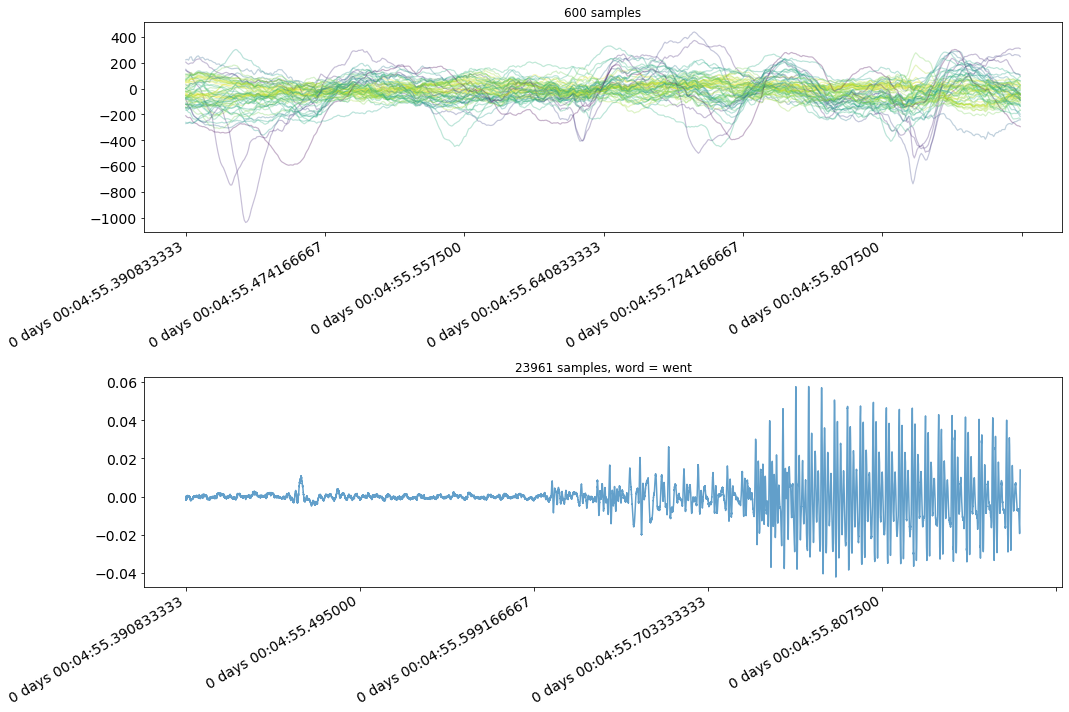

In [5]:
nww.sample_plot(0)

In [6]:
from ipywidgets import interact, widgets
interact(lambda i: nww.sample_plot(i), # interact bugs out if i don't wrap in lambda ...
         i=widgets.IntSlider(0, 0, len(nww)))

interactive(children=(IntSlider(value=0, description='i', max=27569), Output()), _dom_classes=('widget-interac…

<function __main__.<lambda>(i)>

In [7]:
pd.Series(nww.data_map[('Mayo Clinic', 19, 1, 1)]['start_times_d']).sample(10)

23-not     0 days 00:01:16
63-cap     0 days 00:03:16
83-vest    0 days 00:04:16
2-ride     0 days 00:00:13
6-ray      0 days 00:00:25
39-that    0 days 00:02:04
1-fish     0 days 00:00:10
102-sill   0 days 00:05:13
52-may     0 days 00:02:43
47-cash    0 days 00:02:28
dtype: timedelta64[ns]

**Data mapped by:**
- location, patient, session, trial

In [8]:
nww.data_map.keys()

dict_keys([('Mayo Clinic', 19, 1, 1), ('Mayo Clinic', 19, 1, 3)])

In [9]:
nww.data_map[('Mayo Clinic', 19, 1, 1)].keys()

dict_keys(['fs_audio', 'fs_signal', 'ecog_all', 'ecog', 'audio', 'channel_status', 'stim', 'stim_diff', 'sensor_columns', 'word_code_d', 'remap', 'start_times_d', 'stop_times_d', 'stim_pwrq', 'stim_pwrq_diff', 'rolling_audio_pwr'])

In [10]:
nww.data_map[('Mayo Clinic', 19, 1, 1)]['ecog'].head(2)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0 days 00:00:00,403.231506,359.150452,484.076538,512.329468,465.248047,625.540833,444.715576,494.397125,612.269409,495.830719,...,408.664429,611.472168,525.637634,554.565186,422.149475,693.867676,786.910217,688.366150,544.571655,641.040344
0 days 00:00:00.000833333,405.974274,364.886719,485.589203,523.906555,474.702026,626.282166,463.848206,498.329651,627.798523,526.206848,...,430.367889,613.682983,530.103760,551.097839,415.895203,687.121216,796.887146,692.931519,544.806030,638.971436


In [11]:
nww.data_map[('Mayo Clinic', 19, 1, 1)]['audio'].shape

(16887643,)

****

## Mat to Pandas
- **Cells below are the major components of the `NorthwesternWords.mat_arr_to_pandas()` static method**
- Use these cells for experimenting/debugging/understanding/etc

Data from nww.data_map attribute is already parsed into Pandas, so load directly without wrangling using as_frames=False

In [12]:
mat_d = datasets.NorthwesternWords.load_data( 'Mayo Clinic', 19, 1, 1, parse_mat_data=False)
pd_mat_d = nww.data_map[('Mayo Clinic', 19, 1, 1)]

---19-1-1-Mayo Clinic---


Already parsed frames

In [13]:
pd_mat_d['ecog'].head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0 days 00:00:00,403.231506,359.150452,484.076538,512.329468,465.248047,625.540833,444.715576,494.397125,612.269409,495.830719,...,408.664429,611.472168,525.637634,554.565186,422.149475,693.867676,786.910217,688.366150,544.571655,641.040344
0 days 00:00:00.000833333,405.974274,364.886719,485.589203,523.906555,474.702026,626.282166,463.848206,498.329651,627.798523,526.206848,...,430.367889,613.682983,530.103760,551.097839,415.895203,687.121216,796.887146,692.931519,544.806030,638.971436
0 days 00:00:00.001666667,422.167969,391.942810,500.156891,543.153870,487.742126,628.508789,484.343445,507.389740,644.907104,557.870483,...,457.134583,622.850098,539.004089,557.391968,419.017914,686.951843,799.382751,705.532959,549.358459,645.133240
0 days 00:00:00.002500,434.318787,411.240692,514.692810,546.295776,494.608215,623.498901,496.149139,515.848145,657.343079,589.516724,...,491.505615,638.891663,556.617004,569.861389,427.301178,692.407104,804.197876,723.952271,561.939270,655.589050
0 days 00:00:00.003333333,426.537079,417.486450,513.578064,533.056213,488.305695,609.701477,491.048859,510.144745,664.331543,600.378662,...,516.373047,645.198792,558.751770,568.822449,425.300873,688.958191,805.971069,728.566406,568.673035,653.042664


For these cells, need original matlab data to demo

In [14]:
mat_d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ECOG_signal', 'audio', 'fs_audio', 'fs_signal', 'stimcode', 'wordcode', 'electrodes'])

****
Check `data_loader.NorthwesternWords.parse_mat_arr_dict` for current implementation:

In [ ]:
datasets.NorthwesternWords.parse_mat_arr_dict??

***

In [16]:
# Pull out doubly nested scalars
fs_audio = mat_d['fs_audio'][0][0]
fs_signal = mat_d['fs_signal'][0][0]

# Flatten out Stim array 
#- make them regular ints so plenty of headroom and negatives work
stim_arr = mat_d['stimcode'].reshape(-1).astype('int32')

# Create a dictonary map from index to word string repr
# **0 is neutral, word index starts from 1**?
word_code_d = {i+1: w[0] for i, w in enumerate(mat_d['wordcode'].reshape(-1))}
# Code 0 as no-sound/signal/speech
word_code_d[0] = '<ns>'

In [17]:
np.array(sorted(word_code_d.keys()))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

In [18]:
word_code_s = pd.Series(word_code_d, name='word')

word_code_s.index.name = 'word_index'

In [19]:
w_vc = word_code_s.value_counts()
dup_words = w_vc[w_vc > 1].index.tolist()
dup_words

['pig', 'cup']

In [20]:
for dw in dup_words:
    for w_ix in word_code_s[word_code_s == dw].index.tolist():
        word_code_d[w_ix] = dw + ("-%d" % w_ix)
        print(dw + " - %d" % w_ix)

pig - 16
pig - 19
cup - 29
cup - 80


In [21]:
word_code_s = pd.Series(word_code_d, name='word')

word_code_s.index.name = 'word_index'

In [22]:
w_vc = word_code_s.value_counts()
dup_words = w_vc[w_vc > 1].index.tolist()
dup_words

[]

In [23]:
word_code_s.loc[[16, 19, 29, 80]]

word_index
16    pig-16
19    pig-19
29    cup-29
80    cup-80
Name: word, dtype: object

In [24]:
np.unique(stim_arr)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115],
      dtype=int32)

#### Stim parse

In [25]:
# TimedeltaIndex makes a time series object - easier to work with
ix = pd.TimedeltaIndex(pd.RangeIndex(0, stim_arr.shape[0]) / fs_signal, unit='s')

# Load stim and ecog arrays into pandas with the time series index
stim_s = pd.Series(stim_arr, index=ix)
ecog_df = pd.DataFrame(mat_d['ECOG_signal'], index=ix)

In [26]:
# TODO: What are appropriate names for these indicators
chann_code_cols = ["code_%d" % e for e in range(mat_d['electrodes'].shape[-1])]

channel_df = pd.DataFrame(mat_d['electrodes'], columns=chann_code_cols)

In [27]:
channel_df.describe()

,code_0,code_1,code_2,code_3,code_4,code_5
count,96.0,96.0,96.0,96.0,96.0,96.0
mean,1.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,0.0,0.0,0.0,0.0,0.0
50%,1.0,0.0,0.0,0.0,0.0,0.0
75%,1.0,0.0,0.0,0.0,0.0,0.0
max,1.0,0.0,0.0,0.0,0.0,0.0


Time of stim code and total time of neutral
- demonstrates duplication

In [28]:
# How many samples associated with each word
stim_s.map(word_code_d).value_counts()

<ns>    77400
chow     3000
tang     3000
lay      3000
chat     3000
        ...  
cap      3000
hold     3000
mop      3000
pill     3000
fib      3000
Length: 116, dtype: int64

In [29]:
# Convert to seconds
stim_s.map(word_code_d).value_counts()/ fs_signal

<ns>    64.5
chow     2.5
tang     2.5
lay      2.5
chat     2.5
        ... 
cap      2.5
hold     2.5
mop      2.5
pill     2.5
fib      2.5
Length: 116, dtype: float64

Plot data between 6 and 9 seconds to see stim code 

<AxesSubplot:>

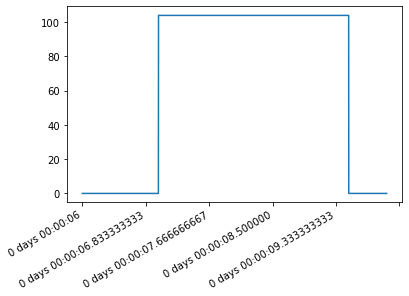

In [30]:
stim_s.loc['6s':'9s'].plot()

#### Audio

In [31]:
# Flatten audio array, make time index for it's size and rate
audio_arr = mat_d['audio'].reshape(-1)
ix = pd.TimedeltaIndex(pd.RangeIndex(0, audio_arr.shape[0]) / fs_audio, unit='s')
audio_s = pd.Series(audio_arr, index=ix)

<AxesSubplot:>

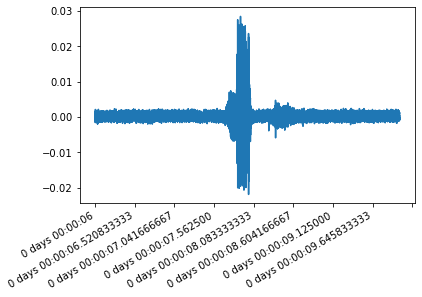

In [32]:
audio_s.loc['6s':'9s'].plot()

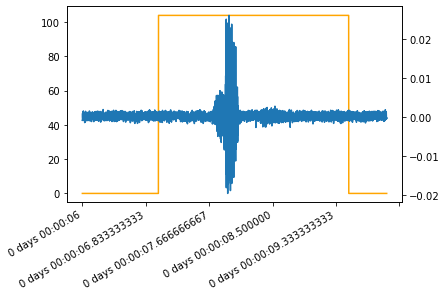

In [33]:
# Stim code is at lower freq (ecog hz), so use it as our base for plotting
# so that we index into the higher frequency with the lower frequency index
# - Otherwise, if indexing from the higher Hz into the lower Hz,
#   more likely to get missing index error and force to '.reindex()'
ax = stim_s.loc['6s':'9s'].plot(color='orange')
ax = audio_s.loc[stim_s.loc['6s':'9s'].index].plot(ax=ax.twinx())

In [34]:
stim_s.value_counts()

0     77400
42     3000
30     3000
31     3000
32     3000
      ...  
81     3000
82     3000
83     3000
84     3000
57     3000
Length: 116, dtype: int64

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: TimedeltaIndex(['0 days 00:00:06.000020833', '0 days 00:00:06.000041667',\n                '0 days 00:00:06.000062500', '0 days 00:00:06.000083333',\n                '0 days 00:00:06.000104167',\n                ...\n                '0 days 00:00:09.999895833', '0 days 00:00:09.999916667',\n                '0 days 00:00:09.999937500', '0 days 00:00:09.999958333',\n                '0 days 00:00:09.999979167'],\n               dtype='timedelta64[ns]', length=187200, freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

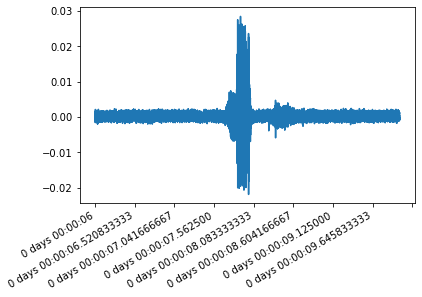

In [35]:
# Doing audio first will require a reindex, which may be fine...?
ax = audio_s.loc['6s':'9s'].plot()
stim_s.loc[audio_s.loc['6s':'9s'].index].plot(ax=ax.twinx(), color='yellow')

#### Stim event codes and txt

In [36]:
stim_diff_s = stim_s.diff()

In [37]:
stim_diff_s[stim_diff_s != 0].loc['6s':'9s']

0 days 00:00:07           104.0
0 days 00:00:09.500000   -104.0
dtype: float64

<AxesSubplot:>

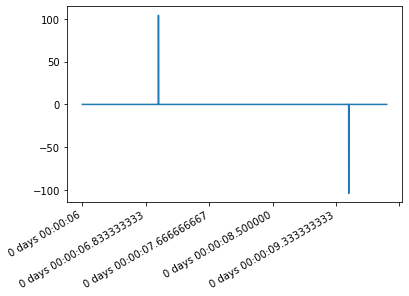

In [38]:
stim_diff_s.loc['6s':'9s'].plot()

Diff will insert a nan at the start
- Fill with 0 and convert to integer

In [39]:
pd.concat([stim_diff_s, stim_diff_s.fillna(0), stim_diff_s.fillna(0).astype(int)], axis=1).describe()

,0,1,2
count,422399.000000,422400.000000,422400.000000
mean,0.000000,0.000000,0.000000
std,1.559417,1.559415,1.559415
min,-115.000000,-115.000000,-115.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,115.000000,115.000000,115.000000


In [40]:
# Positives stim diffs are start times (i.e. going from 0 to positive word code)
start_times_cd = stim_diff_s.loc[stim_diff_s > 0].astype(int)
start_times_txt = start_times_cd.map(word_code_d)

# Negative stim diffs are stop times (going from word code to 0 )
stop_times_cd = stim_diff_s.loc[stim_diff_s < 0].astype(int).abs()
stop_times_txt = stop_times_cd.map(word_code_d)

In [41]:
start_times_txt

0 days 00:00:07     much
0 days 00:00:10     fish
0 days 00:00:13     ride
0 days 00:00:16      bit
0 days 00:00:19     dill
                   ...  
0 days 00:05:37    hitch
0 days 00:05:40     wick
0 days 00:05:43      fun
0 days 00:05:46      was
0 days 00:05:49     seen
Length: 115, dtype: object

In [42]:
stop_times_txt

0 days 00:00:09.500000     much
0 days 00:00:12.500000     fish
0 days 00:00:15.500000     ride
0 days 00:00:18.500000      bit
0 days 00:00:21.500000     dill
                          ...  
0 days 00:05:39.500000    hitch
0 days 00:05:42.500000     wick
0 days 00:05:45.500000      fun
0 days 00:05:48.500000      was
0 days 00:05:51.500000     seen
Length: 115, dtype: object

In [43]:
stim_diff_s = stim_diff_s.fillna(0).astype(int)

In [44]:
stim_diff_s.value_counts()

 0      422170
 85          1
 83          1
 82          1
 81          1
         ...  
-82          1
-83          1
-84          1
-85          1
 115         1
Length: 231, dtype: int64

In [45]:
t_s_indices = nww.make_sample_indices(stim_diff_s, win_size=600)

In [46]:
t_s_ind_keys = list(t_s_indices.keys())
(t_s_ind_keys[:10], t_s_ind_keys[-10:])

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1])

<AxesSubplot:>

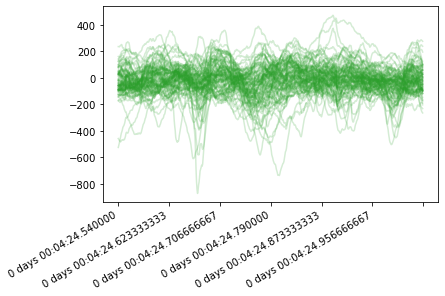

In [47]:
ecog_df.loc[(t_s_indices[115][-1])].plot(legend=False, alpha=0.2, color='tab:green')

<AxesSubplot:>

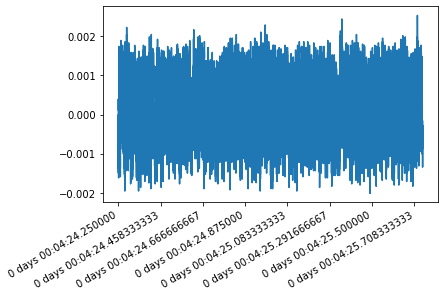

In [54]:
audio_s.loc[t_s_indices[115][0].min(): t_s_indices[115][0].max() + '1s'].plot()

In [49]:
data_k = ('Mayo Clinic', 19, 1, 1)

data_map = nww.data_map[data_k]
audio_s = data_map['audio']

In [50]:
ix_min, ix_max = audio_s.index.min(), audio_s.loc[:'90s'].index.max()

In [51]:
t_indices_s  = {wrd_id: (nww.sample_index_maps[data_k].get(wrd_id), nww.sample_index_maps[data_k].get(-wrd_id))
                for wrd_id in data_map['stim'].loc[ix_min: ix_max].unique() if wrd_id != 0}

plt_audio_s = data_map['audio'].loc[ix_min:ix_max]#.reindex(plt_pred_s.index)
plt_audio_s = plt_audio_s.clip(upper=plt_audio_s.quantile(0.999))

spkn_word_s = (data_map['stim']
               .map(data_map['word_code_d'])
               #.reindex(plt_pred_s.index)
               .fillna(method='ffill'))

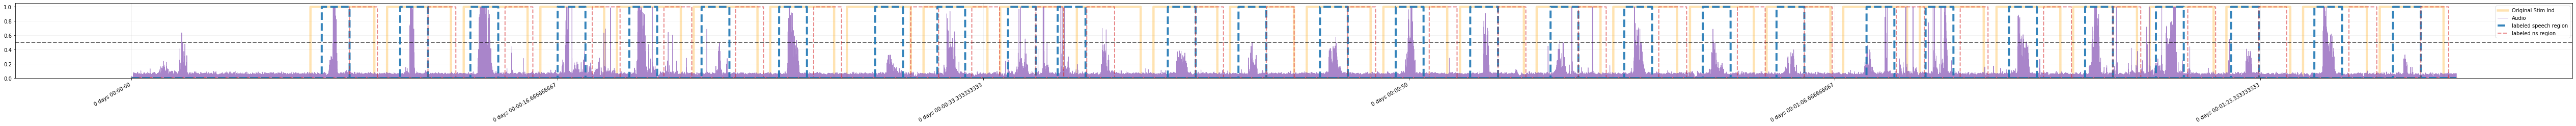

In [53]:
fig, ax = matplotlib.pyplot.subplots(nrows=1, figsize=(90,3.0))

plt_stim_s = ((data_map['stim'] > 0).astype('int16')
      .fillna(method='ffill')
      .loc[ix_min:ix_max].rename("Original Stim Ind"))

ax = (plt_stim_s.plot(color='orange', alpha=0.3, lw=4.5, ls='-', ax=ax, legend=False))
ax = (plt_audio_s/plt_audio_s.max()).rename('Audio').reindex(plt_stim_s.index).plot(color='tab:purple', alpha=0.8, lw=1, ax=ax)

ax.axhline(y=0.5, lw=2, ls='--', alpha=0.35, color='black')
ax.set_ylim(0, 1.05)

ax.axhline(y=0.5, lw=2, ls='--', alpha=0.35, color='black')
ax.set_ylim(0, 1.05)

for ii, (wrd_id, (indices, n_indices)) in enumerate(t_indices_s.items()):
    #print(wrd_id)
    pos_ix_min = indices[0].min()
    pos_ix_max = indices[-1].max()
    ind_ts = pd.Series(0, index=plt_stim_s.index)
    ind_ts.loc[pos_ix_min:pos_ix_max] = 1
    ind_ts.plot(ax=ax, color='tab:blue', # if i == 0 else 'tab:red',
                alpha=.9, label='labeled speech region',
                lw=4., ls='--', legend=False)
    
    n_ix_min = n_indices[0].min()
    n_ix_max = n_indices[-1].max()
    ind_ts = pd.Series(0, index=plt_stim_s.index)
    ind_ts.loc[n_ix_min:n_ix_max] = 1
    ind_ts.plot(ax=ax, color='tab:red', # if i == 0 else 'tab:red',
                alpha=0.55, label='labeled ns region',
                lw=2., ls='--', legend=False)    
    
    if ii == 0:
        ax.legend(loc=(0., 1.))#, ncol=4)

    
ax.grid(True, alpha=0.2)